# Análisis Exploratorio de Modelos para Clasificación de Emociones en Tweets


Estudio exploratorio de 3 modelos para la tarea de clasificación de emociones
Dataset: EmoEvent con 8409 tweets anotados en 8 categorías
Categorías: anger, sadness, joy, disgust, fear, surprise, offensive, other

## 1. Librerias y paquetes necesarios

In [1]:
!pip install transformers datasets evaluate scikit-learn seaborn matplotlib pandas numpy torch
!pip install accelerate -U
!pip install openai

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Librerías de ML
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.utils.class_weight import compute_class_weight

# Librerías de Deep Learning
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    TrainingArguments, Trainer, pipeline
)

# Configuración
plt.style.use('default')
sns.set_palette("husl")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Dispositivo disponible: {device}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 4.1 MB/s eta 0:00:00
Dispositivo disponible: cuda


## 2. Carga de Datos

In [2]:
def load_data():
    """Carga los datos desde GitHub"""
    base_url = "https://raw.githubusercontent.com/fmplaza/EmoEvent/refs/heads/master/splits/es/"

    train_df = pd.read_csv(f"{base_url}train.tsv", sep='\t')
    dev_df = pd.read_csv(f"{base_url}dev.tsv", sep='\t')
    test_df = pd.read_csv(f"{base_url}test.tsv", sep='\t')

    return train_df, dev_df, test_df

print("Cargando datos...")
train_df, dev_df, test_df = load_data()

print(f"Train: {len(train_df)} samples")
print(f"Dev: {len(dev_df)} samples")
print(f"Test: {len(test_df)} samples")
print(f"Total: {len(train_df) + len(dev_df) + len(test_df)} samples")

# Mapeo de emociones a números
emotion_mapping = {
    'anger': 0, 'sadness': 1, 'joy': 2, 'disgust': 3,
    'fear': 4, 'surprise': 5, 'others': 6
}

# Mapeo inverso
id_to_emotion = {v: k for k, v in emotion_mapping.items()}

def prepare_data(df):
    """Prepara los datos para el entrenamiento"""
    df = df.copy()
    df['emotion_id'] = df['emotion'].map(emotion_mapping)
    return df

train_df = prepare_data(train_df)
dev_df = prepare_data(dev_df)
test_df = prepare_data(test_df)

print("\nPrimeras 5 filas del conjunto de entrenamiento:")
print(train_df.head())

Cargando datos...
Train: 5723 samples
Dev: 844 samples
Test: 1656 samples
Total: 8223 samples

Primeras 5 filas del conjunto de entrenamiento:
                                     id          event  \
0  a0c1a858-a9b8-4cb1-8a81-1602736ff5b8  GameOfThrones   
1  9b272817-a231-4f68-bdf4-3350d4919330      Venezuela   
2  4bd5b1e5-4b74-440a-82f4-c2567a241011      NotreDame   
3  0bb9d7c9-d781-4684-890e-a94bfb50acc0      NotreDame   
4  88749098-d539-4500-9209-0bbfae2b109c  GameOfThrones   

                                               tweet offensive  emotion  \
0  La Gran Guerra de #JuegoDeTronos nos ha dejado...        NO   others   
1  El golpe de Estado en #Venezuela está más lejo...        NO   others   
2  No tengo una foto en la catedral de #NotreDame...        NO  sadness   
3  #NotreDame nunca llegue a visitar tan grandios...        NO  sadness   
4      A tomar por culo mi crush 😭😭😭😭😭#JuegoDeTronos       OFF  sadness   

   emotion_id  
0           6  
1           6  
2        

## 3. EDA

=== ANÁLISIS DE DISTRIBUCIÓN DE CLASES ===


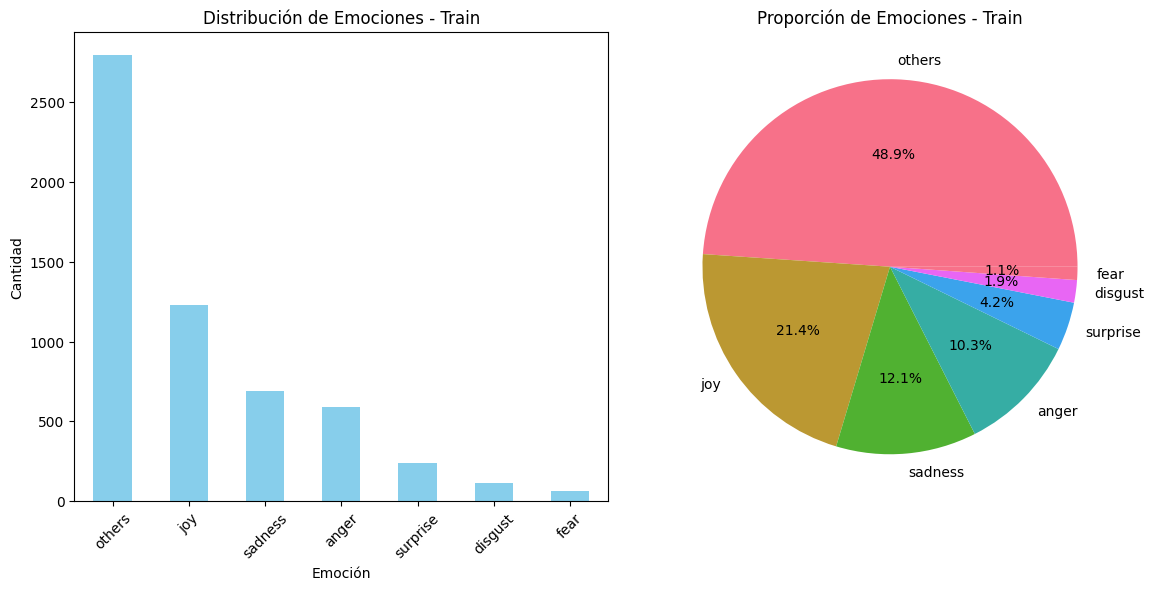


Distribución en Train:
others: 2800 (48.9%)
joy: 1227 (21.4%)
sadness: 693 (12.1%)
anger: 589 (10.3%)
surprise: 238 (4.2%)
disgust: 111 (1.9%)
fear: 65 (1.1%)


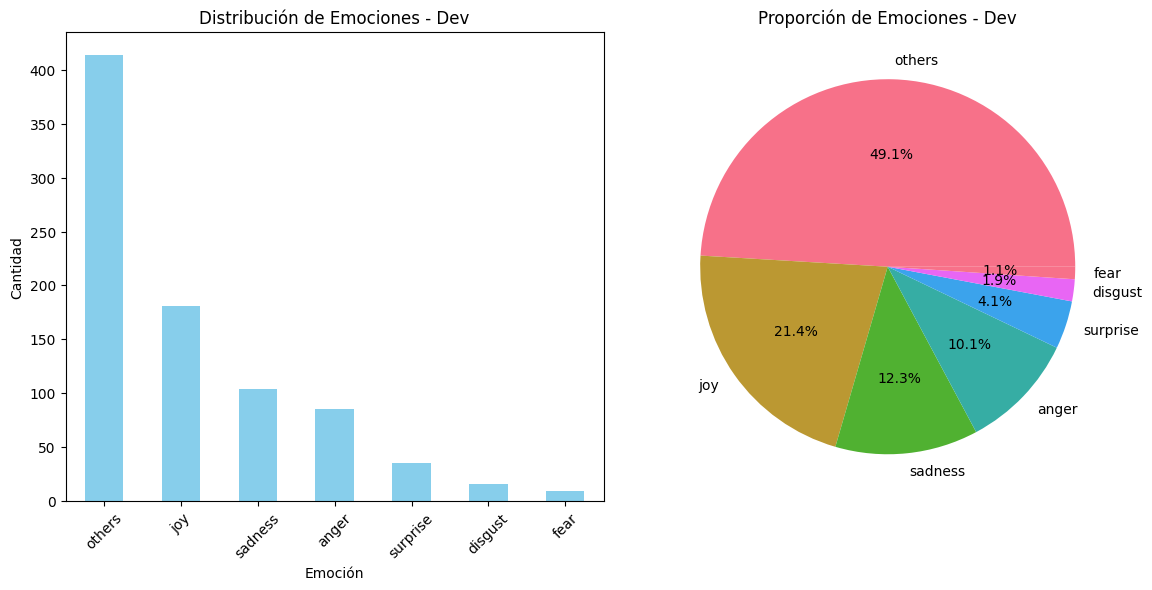


Distribución en Dev:
others: 414 (49.1%)
joy: 181 (21.4%)
sadness: 104 (12.3%)
anger: 85 (10.1%)
surprise: 35 (4.1%)
disgust: 16 (1.9%)
fear: 9 (1.1%)

=== ANÁLISIS POR EVENTOS ===


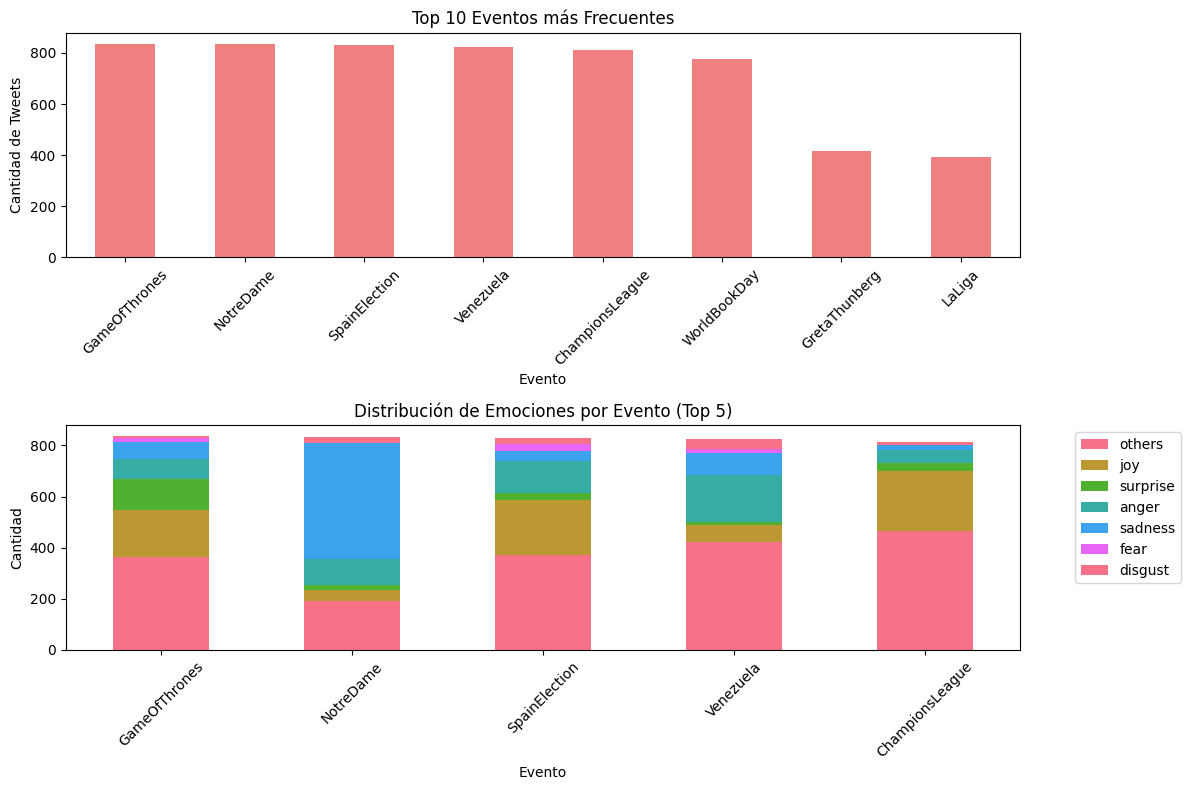

In [3]:
def plot_emotion_distribution(df, title):
    """Visualiza la distribución de emociones"""
    emotion_counts = df['emotion'].value_counts()

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    emotion_counts.plot(kind='bar', color='skyblue')
    plt.title(f'Distribución de Emociones - {title}')
    plt.xlabel('Emoción')
    plt.ylabel('Cantidad')
    plt.xticks(rotation=45)

    plt.subplot(1, 2, 2)
    plt.pie(emotion_counts.values, labels=emotion_counts.index, autopct='%1.1f%%')
    plt.title(f'Proporción de Emociones - {title}')

    plt.tight_layout()
    plt.show()

    print(f"\nDistribución en {title}:")
    for emotion, count in emotion_counts.items():
        percentage = (count / len(df)) * 100
        print(f"{emotion}: {count} ({percentage:.1f}%)")

print("=== ANÁLISIS DE DISTRIBUCIÓN DE CLASES ===")
plot_emotion_distribution(train_df, "Train")
plot_emotion_distribution(dev_df, "Dev")

def analyze_events(df):
    """Analiza la distribución por eventos"""
    event_counts = df['event'].value_counts()

    plt.figure(figsize=(12, 8))
    plt.subplot(2, 1, 1)
    event_counts.head(10).plot(kind='bar', color='lightcoral')
    plt.title('Top 10 Eventos más Frecuentes')
    plt.xlabel('Evento')
    plt.ylabel('Cantidad de Tweets')
    plt.xticks(rotation=45)

    # Distribución de emociones por evento (top 5 eventos)
    plt.subplot(2, 1, 2)
    top_events = event_counts.head(5).index
    event_emotion_data = []

    for event in top_events:
        event_data = df[df['event'] == event]['emotion'].value_counts()
        event_emotion_data.append(event_data)

    event_emotion_df = pd.DataFrame(event_emotion_data, index=top_events).fillna(0)
    event_emotion_df.plot(kind='bar', stacked=True, ax=plt.gca())
    plt.title('Distribución de Emociones por Evento (Top 5)')
    plt.xlabel('Evento')
    plt.ylabel('Cantidad')
    plt.xticks(rotation=45)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    plt.show()

    return event_counts

print("\n=== ANÁLISIS POR EVENTOS ===")
event_counts = analyze_events(train_df)

## 4. Procesamiento de Texto

In [4]:
import re
from sklearn.preprocessing import LabelEncoder

def preprocess_text(text):
    """Preprocesamiento básico del texto"""
    if pd.isna(text):
        return ""

    # Convertir a minúsculas
    text = text.lower()

    # Remover URLs
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'www\S+', '', text)

    # Remover menciones de usuario pero conservar el contexto
    text = re.sub(r'@\w+', 'USER', text)

    # Limpiar espacios extra
    text = re.sub(r'\s+', ' ', text).strip()

    return text

# Aplicar preprocesamiento
train_df['tweet_clean'] = train_df['tweet'].apply(preprocess_text)
dev_df['tweet_clean'] = dev_df['tweet'].apply(preprocess_text)
test_df['tweet_clean'] = test_df['tweet'].apply(preprocess_text)

print("Ejemplo de preprocesamiento:")
print(f"Original: {train_df['tweet'].iloc[0]}")
print(f"Procesado: {train_df['tweet_clean'].iloc[0]}")

Ejemplo de preprocesamiento:
Original: La Gran Guerra de #JuegoDeTronos nos ha dejado muchos momentos para el recuerdo y unas cuantas dudas https://t.co/UE7lCgLSez https://t.co/OO3tjUR34c
Procesado: la gran guerra de #juegodetronos nos ha dejado muchos momentos para el recuerdo y unas cuantas dudas


## 5. MODELO 1: BASELINE CON LOGISTIC REGRESSION + TF-IDF

In [5]:
print("\n" + "="*50)
print("MODELO 1: LOGISTIC REGRESSION + TF-IDF")
print("="*50)

class BaselineModel:
    def __init__(self, max_features=10000):
        self.vectorizer = TfidfVectorizer(
            max_features=max_features,
            ngram_range=(1, 2),
            stop_words=None,  # Mantenemos stopwords para español
            min_df=2,
            max_df=0.95
        )
        self.model = LogisticRegression(
            max_iter=1000,
            class_weight='balanced',  # Para manejar desbalance
            random_state=42
        )

    def fit(self, X_train, y_train):
        print("Vectorizando texto...")
        X_train_vec = self.vectorizer.fit_transform(X_train)
        print(f"Dimensiones del vector TF-IDF: {X_train_vec.shape}")

        print("Entrenando modelo...")
        self.model.fit(X_train_vec, y_train)
        return self

    def predict(self, X_test):
        X_test_vec = self.vectorizer.transform(X_test)
        return self.model.predict(X_test_vec)

    def predict_proba(self, X_test):
        X_test_vec = self.vectorizer.transform(X_test)
        return self.model.predict_proba(X_test_vec)

# Entrenamiento del modelo baseline
baseline_model = BaselineModel()
baseline_model.fit(train_df['tweet_clean'], train_df['emotion_id'])

# Predicciones
dev_pred_baseline = baseline_model.predict(dev_df['tweet_clean'])
test_pred_baseline = baseline_model.predict(test_df['tweet_clean'])

# Evaluación
print("\n=== RESULTADOS MODELO BASELINE ===")
print("Resultados en conjunto de validación:")
print(classification_report(dev_df['emotion_id'], dev_pred_baseline,
                          target_names=list(emotion_mapping.keys()), digits=4))


MODELO 1: LOGISTIC REGRESSION + TF-IDF
Vectorizando texto...
Dimensiones del vector TF-IDF: (5723, 10000)
Entrenando modelo...

=== RESULTADOS MODELO BASELINE ===
Resultados en conjunto de validación:
              precision    recall  f1-score   support

       anger     0.3864    0.6000    0.4700        85
     sadness     0.6356    0.7212    0.6757       104
         joy     0.5023    0.5912    0.5431       181
     disgust     0.1818    0.1250    0.1481        16
        fear     0.6364    0.7778    0.7000         9
    surprise     0.1688    0.3714    0.2321        35
      others     0.7730    0.5266    0.6264       414

    accuracy                         0.5604       844
   macro avg     0.4692    0.5304    0.4851       844
weighted avg     0.6214    0.5604    0.5743       844



## 6. MODELO 2: FINE-TUNING BERT MULTILENGUAJE

In [6]:
print("\n" + "="*50)
print("MODELO 2: FINE-TUNING BERT MULTILINGUAL")
print("="*50)

class TwitterDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }

# Configuración del modelo BERT
model_name = "bert-base-multilingual-cased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=8,
    problem_type="single_label_classification"
)

# Preparar datasets
train_dataset = TwitterDataset(
    train_df['tweet_clean'].tolist(),
    train_df['emotion_id'].tolist(),
    tokenizer
)

dev_dataset = TwitterDataset(
    dev_df['tweet_clean'].tolist(),
    dev_df['emotion_id'].tolist(),
    tokenizer
)

# Configuración de entrenamiento
training_args = TrainingArguments(
    output_dir='./results_bert',
    num_train_epochs=2,  # Reducido para tiempo limitado, y evitar sobreajuste
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    warmup_steps=100,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=100,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    fp16=True,  # Para acelerar entrenamiento en GPU
    dataloader_num_workers=0,  # Para evitar problemas en Colab
    remove_unused_columns=False,
)

# Función de métricas
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return {
        'f1_macro': f1_score(labels, predictions, average='macro'),
        'f1_weighted': f1_score(labels, predictions, average='weighted')
    }

# Entrenador
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=dev_dataset,
    compute_metrics=compute_metrics,
)

# Entrenamiento
print("Iniciando fine-tuning de BERT...")

trainer.train()

# Evaluación
print("\n=== RESULTADOS MODELO BERT ===")
eval_results = trainer.evaluate()
print(f"Loss de validación: {eval_results['eval_loss']:.4f}")
print(f"F1 Macro: {eval_results['eval_f1_macro']:.4f}")
print(f"F1 Weighted: {eval_results['eval_f1_weighted']:.4f}")

# Predicciones en conjunto de prueba
test_dataset = TwitterDataset(
    test_df['tweet_clean'].tolist(),
    [0] * len(test_df),  # Labels dummy para test
    tokenizer
)

predictions = trainer.predict(test_dataset)
test_pred_bert = np.argmax(predictions.predictions, axis=1)

# También predicciones para dev set
dev_predictions = trainer.predict(dev_dataset)
dev_pred_bert = np.argmax(dev_predictions.predictions, axis=1)

print("Resultados detallados en conjunto de validación:")
print(classification_report(dev_df['emotion_id'], dev_pred_bert,
                          target_names=list(emotion_mapping.keys()), digits=4))


MODELO 2: FINE-TUNING BERT MULTILINGUAL


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Iniciando fine-tuning de BERT...


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: gnu936 (gnu936-universidad-nacional-de-trujillo) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,F1 Macro,F1 Weighted
1,1.100600,0.981524,0.358677,0.620870
2,0.824400,0.885797,0.504265,0.679527



=== RESULTADOS MODELO BERT ===


Loss de validación: 0.8858
F1 Macro: 0.5043
F1 Weighted: 0.6795


Resultados detallados en conjunto de validación:
              precision    recall  f1-score   support

       anger     0.5278    0.6706    0.5907        85
     sadness     0.6893    0.6827    0.6860       104
         joy     0.6630    0.6630    0.6630       181
     disgust     0.0000    0.0000    0.0000        16
        fear     0.6250    0.5556    0.5882         9
    surprise     0.6250    0.1429    0.2326        35
      others     0.7500    0.7899    0.7694       414

    accuracy                         0.6931       844
   macro avg     0.5543    0.5006    0.5043       844
weighted avg     0.6807    0.6931    0.6795       844



## 7. MODELO 3: RED NEURONAL RECURRENTE (LSTM)

In [7]:
print("\n" + "="*50)
print("MODELO 3: RED NEURONAL RECURRENTE (LSTM)")
print("="*50)

from torch.nn.utils.rnn import pad_sequence
from sklearn.preprocessing import LabelEncoder
import torch.nn.functional as F

class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_classes, num_layers=2, dropout=0.3):
        super(LSTMClassifier, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, num_layers,
                           batch_first=True, dropout=dropout, bidirectional=True)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim * 2, num_classes)  # *2 for bidirectional

    def forward(self, x, lengths):
        embedded = self.embedding(x)

        # Pack padded sequence
        packed = nn.utils.rnn.pack_padded_sequence(embedded, lengths,
                                                  batch_first=True, enforce_sorted=False)
        lstm_out, (hidden, _) = self.lstm(packed)

        # Use the last hidden state from both directions
        hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)

        output = self.dropout(hidden)
        output = self.fc(output)
        return output

class TextProcessor:
    def __init__(self, max_vocab_size=10000, max_length=100):
        self.max_vocab_size = max_vocab_size
        self.max_length = max_length
        self.word_to_idx = {'<PAD>': 0, '<UNK>': 1}
        self.idx_to_word = {0: '<PAD>', 1: '<UNK>'}

    def build_vocab(self, texts):
        word_freq = Counter()
        for text in texts:
            words = text.lower().split()
            word_freq.update(words)

        most_common = word_freq.most_common(self.max_vocab_size - 2)

        for i, (word, _) in enumerate(most_common):
            idx = i + 2
            self.word_to_idx[word] = idx
            self.idx_to_word[idx] = word

        print(f"Vocabulario construido con {len(self.word_to_idx)} palabras")

    def texts_to_sequences(self, texts):
        sequences = []
        lengths = []

        for text in texts:
            words = text.lower().split()[:self.max_length]
            sequence = [self.word_to_idx.get(word, 1) for word in words]  # 1 = <UNK>
            sequences.append(sequence)
            lengths.append(len(sequence))

        return sequences, lengths

class LSTMDataset(Dataset):
    def __init__(self, sequences, lengths, labels):
        self.sequences = sequences
        self.lengths = lengths
        self.labels = labels

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return {
            'sequence': torch.tensor(self.sequences[idx], dtype=torch.long),
            'length': self.lengths[idx],
            'label': torch.tensor(self.labels[idx], dtype=torch.long)
        }

def collate_fn(batch):
    sequences = [item['sequence'] for item in batch]
    lengths = [item['length'] for item in batch]
    labels = [item['label'] for item in batch]

    # Pad sequences
    sequences_padded = pad_sequence(sequences, batch_first=True, padding_value=0)

    return {
        'sequences': sequences_padded,
        'lengths': torch.tensor(lengths),
        'labels': torch.stack(labels)
    }

# Procesamiento de texto para LSTM
text_processor = TextProcessor(max_vocab_size=10000, max_length=100)
text_processor.build_vocab(train_df['tweet_clean'].tolist())

# Convertir textos a secuencias
train_sequences, train_lengths = text_processor.texts_to_sequences(train_df['tweet_clean'].tolist())
dev_sequences, dev_lengths = text_processor.texts_to_sequences(dev_df['tweet_clean'].tolist())
test_sequences, test_lengths = text_processor.texts_to_sequences(test_df['tweet_clean'].tolist())

# Crear datasets
train_lstm_dataset = LSTMDataset(train_sequences, train_lengths, train_df['emotion_id'].tolist())
dev_lstm_dataset = LSTMDataset(dev_sequences, dev_lengths, dev_df['emotion_id'].tolist())
test_lstm_dataset = LSTMDataset(test_sequences, test_lengths, [0] * len(test_df))

# DataLoaders
train_loader = DataLoader(train_lstm_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
dev_loader = DataLoader(dev_lstm_dataset, batch_size=64, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_lstm_dataset, batch_size=64, shuffle=False, collate_fn=collate_fn)

# Create a list to hold the labels
test_labels_single = []

# Filter sequences with length 0
test_sequences_filtered = []
test_lengths_filtered = []

for i in range(len(test_sequences)):
    if test_lengths[i] > 0:
        test_sequences_filtered.append(test_sequences[i])
        test_lengths_filtered.append(test_lengths[i])
        # For each valid sequence, add a single placeholder label (e.g., 0)
        test_labels_single.append(0)

# Recreate the dataset and the dataloader
test_lstm_dataset = LSTMDataset(test_sequences_filtered, test_lengths_filtered, test_labels_single)
test_loader = DataLoader(test_lstm_dataset, batch_size=64, shuffle=False, collate_fn=collate_fn)

# Modelo LSTM
lstm_model = LSTMClassifier(
    vocab_size=len(text_processor.word_to_idx),
    embed_dim=128,
    hidden_dim=64,
    num_classes=7,
    num_layers=2,
    dropout=0.3
).to(device)

# Configuración de entrenamiento
criterion = nn.CrossEntropyLoss(weight=torch.tensor([1.0, 3.0, 5.0, 1.5, 1.0, 2.0, 1.0]).to(device))
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2, factor=0.5)

# Función de entrenamiento
def train_lstm_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for batch in loader:
        sequences = batch['sequences'].to(device)
        lengths = batch['lengths']
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        outputs = model(sequences, lengths)
        loss = criterion(outputs, labels)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    return total_loss / len(loader), correct / total

def evaluate_lstm(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for batch in loader:
            sequences = batch['sequences'].to(device)
            lengths = batch['lengths']
            labels = batch['labels'].to(device)

            outputs = model(sequences, lengths)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)

            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return total_loss / len(loader), all_predictions, all_labels

# Entrenamiento del modelo LSTM
print("Iniciando entrenamiento del modelo LSTM...")

num_epochs = 10
best_f1 = 0
patience_counter = 0

for epoch in range(num_epochs):
    train_loss, train_acc = train_lstm_epoch(lstm_model, train_loader, criterion, optimizer, device)
    val_loss, val_pred, val_true = evaluate_lstm(lstm_model, dev_loader, criterion, device)

    f1_macro = f1_score(val_true, val_pred, average='macro')
    f1_weighted = f1_score(val_true, val_pred, average='weighted')

    scheduler.step(val_loss)

    print(f'Epoch {epoch+1}/{num_epochs}:')
    print(f'  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')
    print(f'  Val Loss: {val_loss:.4f}, F1 Macro: {f1_macro:.4f}, F1 Weighted: {f1_weighted:.4f}')

    if f1_macro > best_f1:
        best_f1 = f1_macro
        torch.save(lstm_model.state_dict(), 'best_lstm_model.pth')
        patience_counter = 0
    else:
        patience_counter += 1

    if patience_counter >= 3:
        print("Early stopping!")
        break

# Cargar el mejor modelo
lstm_model.load_state_dict(torch.load('best_lstm_model.pth'))

# Predicciones finales
_, dev_pred_lstm, dev_true_lstm = evaluate_lstm(lstm_model, dev_loader, criterion, device)
_, test_pred_lstm, _ = evaluate_lstm(lstm_model, test_loader, criterion, device)

print("\n=== RESULTADOS MODELO LSTM ===")
print("Resultados en conjunto de validación:")
print(classification_report(dev_true_lstm, dev_pred_lstm,
                          target_names=list(emotion_mapping.keys()), digits=4))


MODELO 3: RED NEURONAL RECURRENTE (LSTM)
Vocabulario construido con 10000 palabras
Iniciando entrenamiento del modelo LSTM...
Epoch 1/10:
  Train Loss: 1.3383, Train Acc: 0.2378
  Val Loss: 1.1403, F1 Macro: 0.1377, F1 Weighted: 0.1868
Epoch 2/10:
  Train Loss: 1.0678, Train Acc: 0.4043
  Val Loss: 1.0346, F1 Macro: 0.2143, F1 Weighted: 0.3839
Epoch 3/10:
  Train Loss: 0.8989, Train Acc: 0.5226
  Val Loss: 1.0465, F1 Macro: 0.2608, F1 Weighted: 0.4735
Epoch 4/10:
  Train Loss: 0.7404, Train Acc: 0.6166
  Val Loss: 1.0783, F1 Macro: 0.2404, F1 Weighted: 0.4458
Epoch 5/10:
  Train Loss: 0.5856, Train Acc: 0.7003
  Val Loss: 1.2974, F1 Macro: 0.2912, F1 Weighted: 0.5242
Epoch 6/10:
  Train Loss: 0.4222, Train Acc: 0.7772
  Val Loss: 1.4087, F1 Macro: 0.2946, F1 Weighted: 0.5196
Epoch 7/10:
  Train Loss: 0.3390, Train Acc: 0.8205
  Val Loss: 1.6662, F1 Macro: 0.3237, F1 Weighted: 0.5565
Epoch 8/10:
  Train Loss: 0.2753, Train Acc: 0.8454
  Val Loss: 1.7819, F1 Macro: 0.3495, F1 Weighted: 

## 8. COMPARACIÓN DE MODELOS Y ANÁLISIS DETALLADO


COMPARACIÓN DE MODELOS Y ANÁLISIS DETALLADO
=== MATRICES DE CONFUSIÓN ===


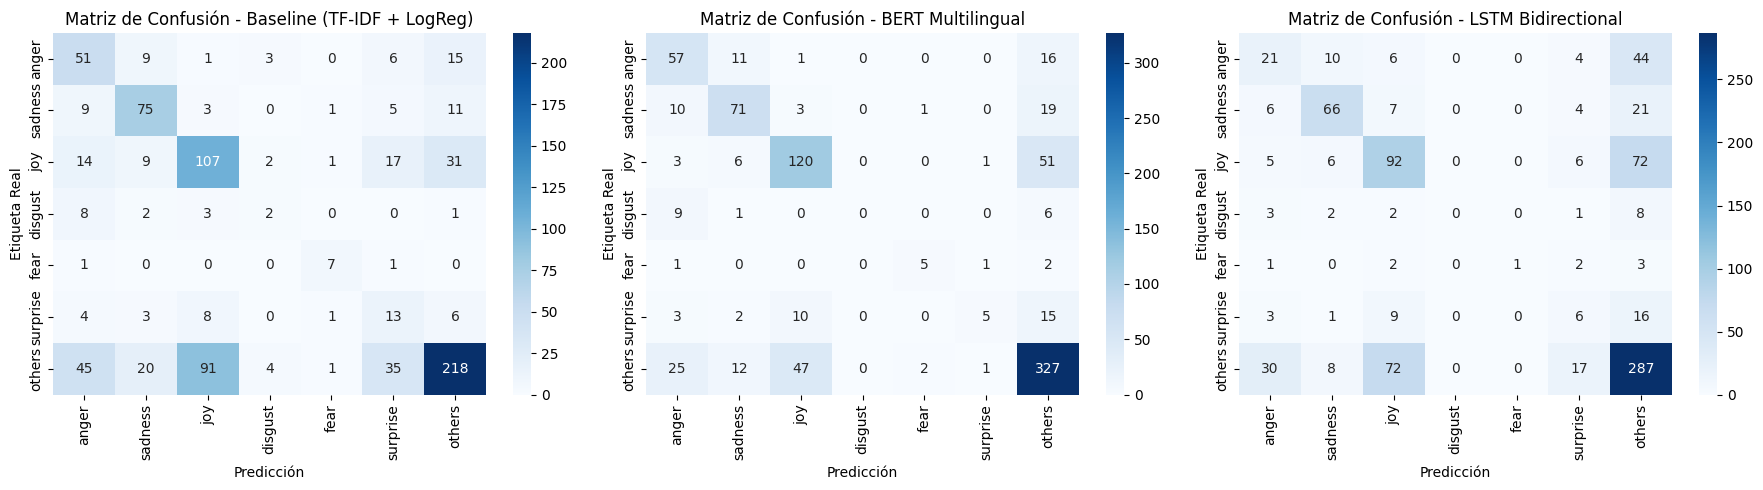


=== ANÁLISIS POR EMOCIÓN ===


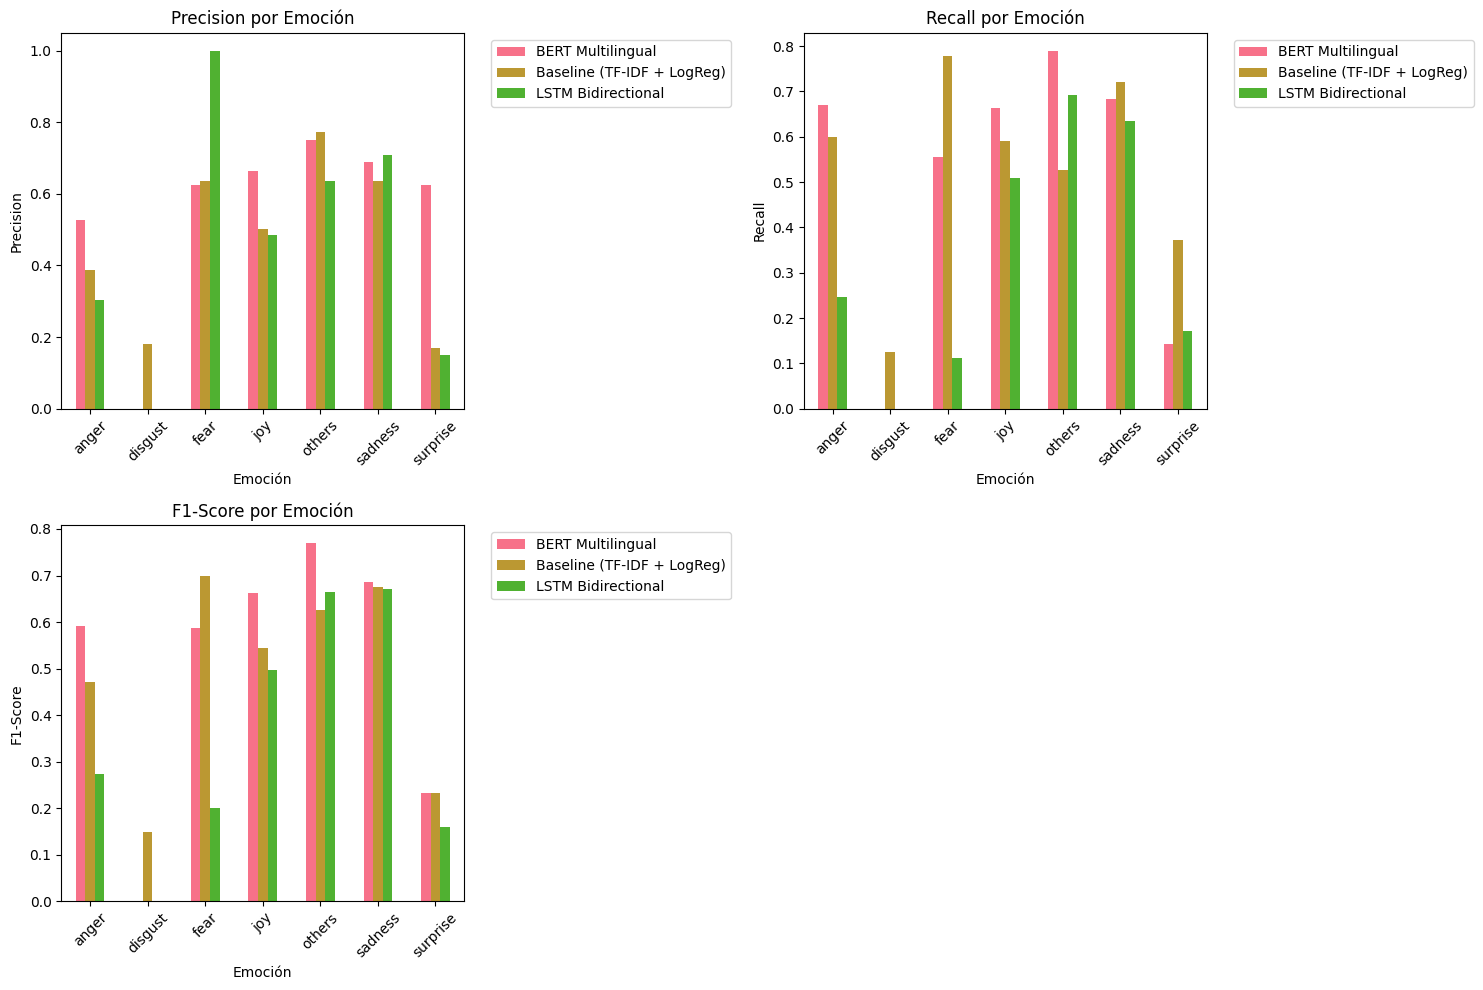


=== TABLA RESUMEN POR EMOCIÓN ===
                    Modelo  Emoción  Precision   Recall  F1-Score  Support
Baseline (TF-IDF + LogReg)    anger   0.386364 0.600000  0.470046     85.0
Baseline (TF-IDF + LogReg)  sadness   0.635593 0.721154  0.675676    104.0
Baseline (TF-IDF + LogReg)      joy   0.502347 0.591160  0.543147    181.0
Baseline (TF-IDF + LogReg)  disgust   0.181818 0.125000  0.148148     16.0
Baseline (TF-IDF + LogReg)     fear   0.636364 0.777778  0.700000      9.0
Baseline (TF-IDF + LogReg) surprise   0.168831 0.371429  0.232143     35.0
Baseline (TF-IDF + LogReg)   others   0.773050 0.526570  0.626437    414.0
         BERT Multilingual    anger   0.527778 0.670588  0.590674     85.0
         BERT Multilingual  sadness   0.689320 0.682692  0.685990    104.0
         BERT Multilingual      joy   0.662983 0.662983  0.662983    181.0
         BERT Multilingual  disgust   0.000000 0.000000  0.000000     16.0
         BERT Multilingual     fear   0.625000 0.555556  0.588235

In [8]:
print("\n" + "="*60)
print("COMPARACIÓN DE MODELOS Y ANÁLISIS DETALLADO")
print("="*60)

def plot_confusion_matrices(y_true, predictions_dict, model_names):
    """Grafica matrices de confusión para todos los modelos"""
    n_models = len(predictions_dict)
    fig, axes = plt.subplots(1, n_models, figsize=(6*n_models, 5))

    if n_models == 1:
        axes = [axes]

    for i, (model_name, y_pred) in enumerate(predictions_dict.items()):
        cm = confusion_matrix(y_true, y_pred)

        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=list(emotion_mapping.keys()),
                   yticklabels=list(emotion_mapping.keys()),
                   ax=axes[i])
        axes[i].set_title(f'Matriz de Confusión - {model_name}')
        axes[i].set_xlabel('Predicción')
        axes[i].set_ylabel('Etiqueta Real')

    plt.tight_layout()
    plt.show()

def analyze_per_emotion_performance(y_true, predictions_dict):
    """Analiza el rendimiento por emoción para todos los modelos"""
    results_df = pd.DataFrame()

    for model_name, y_pred in predictions_dict.items():
        report = classification_report(y_true, y_pred, output_dict=True)

        for emotion, emotion_id in emotion_mapping.items():
            if str(emotion_id) in report:
                row = {
                    'Modelo': model_name,
                    'Emoción': emotion,
                    'Precision': report[str(emotion_id)]['precision'],
                    'Recall': report[str(emotion_id)]['recall'],
                    'F1-Score': report[str(emotion_id)]['f1-score'],
                    'Support': report[str(emotion_id)]['support']
                }
                results_df = pd.concat([results_df, pd.DataFrame([row])], ignore_index=True)

    return results_df

def analyze_by_event(df, predictions_dict):
    """Analiza rendimiento por evento"""
    event_analysis = {}

    for event in df['event'].value_counts().head(5).index:
        event_mask = df['event'] == event
        event_true = df[event_mask]['emotion_id'].values

        print(f"\n=== Análisis para evento: {event} ===")
        print(f"Número de muestras: {len(event_true)}")
        print(f"Distribución de emociones: {Counter(event_true)}")

        for model_name, all_predictions in predictions_dict.items():
            event_pred = np.array(all_predictions)[event_mask]
            f1_macro = f1_score(event_true, event_pred, average='macro', zero_division=0)
            f1_weighted = f1_score(event_true, event_pred, average='weighted', zero_division=0)

            print(f"{model_name} - F1 Macro: {f1_macro:.3f}, F1 Weighted: {f1_weighted:.3f}")

# Diccionario con todas las predicciones
dev_predictions = {
    'Baseline (TF-IDF + LogReg)': dev_pred_baseline,
    'BERT Multilingual': dev_pred_bert,
    'LSTM Bidirectional': dev_pred_lstm
}

print("=== MATRICES DE CONFUSIÓN ===")
plot_confusion_matrices(dev_df['emotion_id'], dev_predictions, list(dev_predictions.keys()))

print("\n=== ANÁLISIS POR EMOCIÓN ===")
emotion_results = analyze_per_emotion_performance(dev_df['emotion_id'], dev_predictions)

# Visualización de resultados por emoción
plt.figure(figsize=(15, 10))

metrics = ['Precision', 'Recall', 'F1-Score']
for i, metric in enumerate(metrics):
    plt.subplot(2, 2, i+1)
    pivot_data = emotion_results.pivot(index='Emoción', columns='Modelo', values=metric)
    pivot_data.plot(kind='bar', ax=plt.gca())
    plt.title(f'{metric} por Emoción')
    plt.xlabel('Emoción')
    plt.ylabel(metric)
    plt.xticks(rotation=45)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

# Tabla resumen
print("\n=== TABLA RESUMEN POR EMOCIÓN ===")
print(emotion_results.to_string(index=False))

print("\n=== ANÁLISIS POR EVENTO ===")
analyze_by_event(dev_df, dev_predictions)

## 9. MÉTRICAS GENERALES Y COMPARACIÓN FINAL


=== MÉTRICAS GENERALES DE COMPARACIÓN ===
                       Modelo  Accuracy  F1 Macro  F1 Weighted  F1 Micro
0  Baseline (TF-IDF + LogReg)    0.5604    0.4851       0.5743    0.5604
1           BERT Multilingual    0.6931    0.5043       0.6795    0.6931
2          LSTM Bidirectional    0.5604    0.3518       0.5507    0.5604


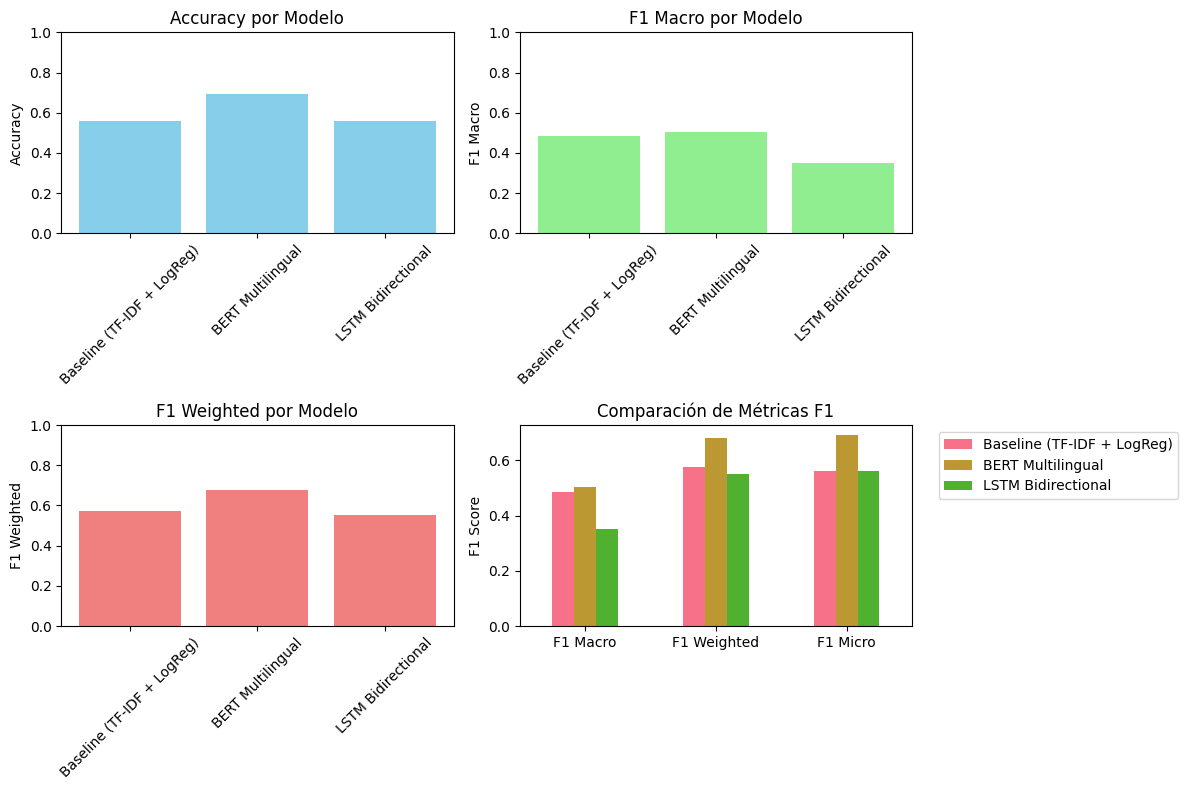

In [9]:
def calculate_overall_metrics(y_true, predictions_dict):
    """Calcula métricas generales para todos los modelos"""
    results = []

    for model_name, y_pred in predictions_dict.items():
        metrics = {
            'Modelo': model_name,
            'Accuracy': (y_true == y_pred).mean(),
            'F1 Macro': f1_score(y_true, y_pred, average='macro'),
            'F1 Weighted': f1_score(y_true, y_pred, average='weighted'),
            'F1 Micro': f1_score(y_true, y_pred, average='micro')
        }
        results.append(metrics)

    return pd.DataFrame(results)

print("\n=== MÉTRICAS GENERALES DE COMPARACIÓN ===")
overall_metrics = calculate_overall_metrics(dev_df['emotion_id'], dev_predictions)
print(overall_metrics.round(4))

# Visualización de métricas generales
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.bar(overall_metrics['Modelo'], overall_metrics['Accuracy'], color='skyblue')
plt.title('Accuracy por Modelo')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.ylim(0, 1)

plt.subplot(2, 2, 2)
plt.bar(overall_metrics['Modelo'], overall_metrics['F1 Macro'], color='lightgreen')
plt.title('F1 Macro por Modelo')
plt.ylabel('F1 Macro')
plt.xticks(rotation=45)
plt.ylim(0, 1)

plt.subplot(2, 2, 3)
plt.bar(overall_metrics['Modelo'], overall_metrics['F1 Weighted'], color='lightcoral')
plt.title('F1 Weighted por Modelo')
plt.ylabel('F1 Weighted')
plt.xticks(rotation=45)
plt.ylim(0, 1)

plt.subplot(2, 2, 4)
metrics_comparison = overall_metrics.set_index('Modelo')[['F1 Macro', 'F1 Weighted', 'F1 Micro']].T
metrics_comparison.plot(kind='bar', ax=plt.gca())
plt.title('Comparación de Métricas F1')
plt.ylabel('F1 Score')
plt.xticks(rotation=0)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

## 10. ANÁLISIS DE ERRORES Y CASOS INTERESANTES

In [10]:
print("\n" + "="*60)
print("ANÁLISIS DE ERRORES Y CASOS INTERESANTES")
print("="*60)

def analyze_errors(df, y_true, y_pred, model_name, n_examples=5):
    """Analiza errores del modelo y muestra ejemplos"""
    print(f"\n=== ANÁLISIS DE ERRORES - {model_name} ===")

    # Crear DataFrame con predicciones
    error_df = df.copy()
    error_df['true_label'] = y_true
    error_df['predicted_label'] = y_pred
    error_df['correct'] = error_df['true_label'] == error_df['predicted_label']

    # Estadísticas de errores
    total_errors = (~error_df['correct']).sum()
    accuracy = error_df['correct'].mean()

    print(f"Total de errores: {total_errors} de {len(error_df)} ({total_errors/len(error_df)*100:.1f}%)")
    print(f"Accuracy: {accuracy:.4f}")

    # Errores por emoción
    error_by_emotion = error_df.groupby('emotion')['correct'].agg(['count', 'sum']).reset_index()
    error_by_emotion['error_rate'] = 1 - (error_by_emotion['sum'] / error_by_emotion['count'])
    error_by_emotion = error_by_emotion.sort_values('error_rate', ascending=False)

    print("\nTasa de error por emoción:")
    for _, row in error_by_emotion.iterrows():
        print(f"{row['emotion']}: {row['error_rate']:.3f} ({row['count'] - row['sum']}/{row['count']} errores)")

    # Mostrar ejemplos de errores
    print(f"\n=== EJEMPLOS DE ERRORES ===")
    errors = error_df[~error_df['correct']].sample(min(n_examples, total_errors))

    for i, (_, row) in enumerate(errors.iterrows()):
        true_emotion = id_to_emotion[row['true_label']]
        pred_emotion = id_to_emotion[row['predicted_label']]

        print(f"\nEjemplo {i+1}:")
        print(f"Tweet: {row['tweet'][:100]}...")
        print(f"Evento: {row['event']}")
        print(f"Emoción real: {true_emotion}")
        print(f"Emoción predicha: {pred_emotion}")

    return error_by_emotion

# Análisis de errores para cada modelo
for model_name, predictions in dev_predictions.items():
    analyze_errors(dev_df, dev_df['emotion_id'], predictions, model_name, n_examples=3)


ANÁLISIS DE ERRORES Y CASOS INTERESANTES

=== ANÁLISIS DE ERRORES - Baseline (TF-IDF + LogReg) ===
Total de errores: 371 de 844 (44.0%)
Accuracy: 0.5604

Tasa de error por emoción:
disgust: 0.875 (14/16 errores)
surprise: 0.629 (22/35 errores)
others: 0.473 (196/414 errores)
joy: 0.409 (74/181 errores)
anger: 0.400 (34/85 errores)
sadness: 0.279 (29/104 errores)
fear: 0.222 (2/9 errores)

=== EJEMPLOS DE ERRORES ===

Ejemplo 1:
Tweet: Hoy hablé con uno de mis ex-jefes, me habló del día del libro y el origen de éste. Uno de los jefes ...
Evento: WorldBookDay
Emoción real: others
Emoción predicha: joy

Ejemplo 2:
Tweet: Maldita sea, se los bajaron a todos #JuegodeTronos #GOT...
Evento: GameOfThrones
Emoción real: anger
Emoción predicha: surprise

Ejemplo 3:
Tweet: Arya después de cumplir con lo suyo #GameOfThrones #JuegodeTronos #BattleofWinterfel #Got8x03 #NotTo...
Evento: GameOfThrones
Emoción real: joy
Emoción predicha: surprise

=== ANÁLISIS DE ERRORES - BERT Multilingual ===
Total 

## 11. PREDICCIONES EN CONJUNTO DE PRUEBA


PREDICCIONES EN CONJUNTO DE PRUEBA
Primeras 10 predicciones en el conjunto de prueba:
                                     id          event  \
0  16b25dfb-e284-4a58-b62c-8186fc082eb6  GameOfThrones   
1  2a80f6bf-4750-4783-9bc8-fdb8ff2b94c4  SpainElection   
2  1f477a6f-3559-41ee-8ec5-2e77aee53190   WorldBookDay   
3  838add70-748c-4635-8133-36ff0b05aeb0   WorldBookDay   
4  64e3dd59-ae5c-4b9b-bd29-987609eb95d8  SpainElection   
5  7bc2b439-817a-4a22-9aa3-6ac9e8ebee90      Venezuela   
6  f785d8c5-575a-47e1-9eb4-4217bc8b6bf5  GameOfThrones   
7  e0c36651-df9a-4e3a-9763-84f9a8e3c9b4  SpainElection   
8  0d1ddeb6-ceeb-44b2-9aaf-10fa733e31cb         LaLiga   
9  53de65ff-4f75-4118-b1cb-967647a79e65   WorldBookDay   

                                               tweet  \
0  Señor de luz, ven a nosotros en nuestra oscuri...   
1  Pues ya hemos votado tanto mi madre y yo #Elec...   
2  #DiaDelLibro 😇⭐❤️🙏🙌😍🌷 sentimientos, viajar con...   
3  ¡Feliz #DíaDelLibro📚! ”El libro es fuerza, es .

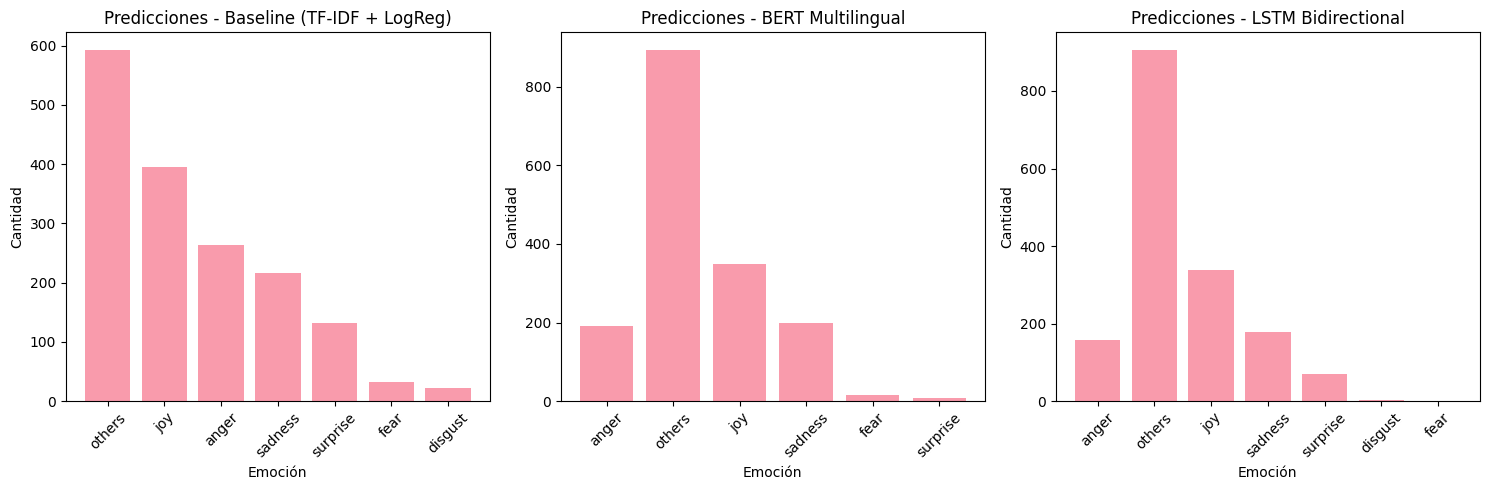


 Predicciones guardadas en 'test_predictions.csv'


In [11]:
print("\n" + "="*60)
print("PREDICCIONES EN CONJUNTO DE PRUEBA")
print("="*60)

# Archivo de predicciones para cada modelo
aligned_test_pred_lstm = [None] * len(test_df)

filtered_indices = [i for i, length in enumerate(test_lengths) if length > 0]
for i, pred in zip(filtered_indices, test_pred_lstm):
    aligned_test_pred_lstm[i] = pred

default_prediction = emotion_mapping['others']
for i in range(len(aligned_test_pred_lstm)):
    if aligned_test_pred_lstm[i] is None:
        aligned_test_pred_lstm[i] = default_prediction

test_predictions = {
    'Baseline (TF-IDF + LogReg)': test_pred_baseline,
    'BERT Multilingual': test_pred_bert,
    'LSTM Bidirectional': aligned_test_pred_lstm
}

# Crear DataFrame con predicciones del conjunto de prueba
test_results_df = test_df[['id', 'event', 'tweet']].copy()

for model_name, predictions in test_predictions.items():
    # Convertir predicciones numéricas a nombres de emociones
    emotion_names = [id_to_emotion[pred] for pred in predictions]
    test_results_df[f'{model_name}_prediction'] = emotion_names

print("Primeras 10 predicciones en el conjunto de prueba:")
print(test_results_df.head(10))

# Análisis de distribución de predicciones en test
print("\n=== DISTRIBUCIÓN DE PREDICCIONES EN CONJUNTO DE PRUEBA ===")

plt.figure(figsize=(15, 5))

for i, (model_name, predictions) in enumerate(test_predictions.items()):
    plt.subplot(1, 3, i+1)
    pred_emotions = [id_to_emotion[pred] for pred in predictions]
    emotion_counts = Counter(pred_emotions)

    plt.bar(emotion_counts.keys(), emotion_counts.values(), alpha=0.7)
    plt.title(f'Predicciones - {model_name}')
    plt.xlabel('Emoción')
    plt.ylabel('Cantidad')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Guardar predicciones
test_results_df.to_csv('test_predictions.csv', index=False)
print("\n Predicciones guardadas en 'test_predictions.csv'")

## 12. ANÁLISIS DE CONSENSO ENTRE MODELOS

In [12]:
print("\n" + "="*60)
print("ANÁLISIS DE CONSENSO ENTRE MODELOS")
print("="*60)

def analyze_model_agreement(predictions_dict, df):
    """Analiza el consenso entre modelos"""

    # Convertir predicciones a DataFrame
    pred_df = pd.DataFrame(predictions_dict)

    # Calcular consenso completo (todos los modelos coinciden)
    full_consensus = (pred_df.iloc[:, 0] == pred_df.iloc[:, 1]) & \
                    (pred_df.iloc[:, 1] == pred_df.iloc[:, 2])

    consensus_rate = full_consensus.mean()
    print(f"Tasa de consenso completo: {consensus_rate:.3f} ({full_consensus.sum()}/{len(pred_df)} casos)")

    # Consenso parcial (al menos 2 modelos coinciden)
    partial_consensus = ((pred_df.iloc[:, 0] == pred_df.iloc[:, 1]) |
                        (pred_df.iloc[:, 0] == pred_df.iloc[:, 2]) |
                        (pred_df.iloc[:, 1] == pred_df.iloc[:, 2]))

    partial_consensus_rate = partial_consensus.mean()
    print(f"Tasa de consenso parcial: {partial_consensus_rate:.3f} ({partial_consensus.sum()}/{len(pred_df)} casos)")

    # Ejemplos donde hay consenso completo
    consensus_examples = df[full_consensus].sample(min(3, full_consensus.sum()))
    print("\n=== EJEMPLOS CON CONSENSO COMPLETO ===")

    for i, (_, row) in enumerate(consensus_examples.iterrows()):
        idx = row.name
        predicted_emotion = id_to_emotion[pred_df.iloc[idx, 0]]

        print(f"\nEjemplo {i+1}:")
        print(f"Tweet: {row['tweet'][:100]}...")
        print(f"Evento: {row['event']}")
        print(f"Predicción unánime: {predicted_emotion}")

    # Ejemplos donde NO hay consenso
    no_consensus = ~partial_consensus
    if no_consensus.sum() > 0:
        disagreement_examples = df[no_consensus].sample(min(3, no_consensus.sum()))
        print("\n=== EJEMPLOS SIN CONSENSO ===")

        for i, (_, row) in enumerate(disagreement_examples.iterrows()):
            idx = row.name
            predictions = [id_to_emotion[pred_df.iloc[idx, j]] for j in range(3)]

            print(f"\nEjemplo {i+1}:")
            print(f"Tweet: {row['tweet'][:100]}...")
            print(f"Evento: {row['event']}")
            print(f"Predicciones: {list(zip(pred_df.columns, predictions))}")

# Análisis de consenso en conjunto de validación
print("=== CONSENSO EN CONJUNTO DE VALIDACIÓN ===")
analyze_model_agreement(dev_predictions, dev_df)

# Análisis de consenso en conjunto de prueba
print("\n=== CONSENSO EN CONJUNTO DE PRUEBA ===")
analyze_model_agreement(test_predictions, test_df)


ANÁLISIS DE CONSENSO ENTRE MODELOS
=== CONSENSO EN CONJUNTO DE VALIDACIÓN ===
Tasa de consenso completo: 0.432 (365/844 casos)
Tasa de consenso parcial: 0.900 (760/844 casos)

=== EJEMPLOS CON CONSENSO COMPLETO ===

Ejemplo 1:
Tweet:  USER Tiene todo mi apoyo. Transparente y objetiva. Gracias por estar ahí. #ElecccionesGenerales28A ...
Evento: SpainElection
Predicción unánime: joy

Ejemplo 2:
Tweet: #Laliga 🇪🇸 | El USER se corona cómo campeón de la #LaLiga Al vencer por la mínima al USER . 📍Bicampe...
Evento: LaLiga
Predicción unánime: joy

Ejemplo 3:
Tweet: El encuentro entre dos generaciones que luchan por la sostenibilidad del planeta 🌎 #GretaThunberg #J...
Evento: GretaThunberg
Predicción unánime: others

=== EJEMPLOS SIN CONSENSO ===

Ejemplo 1:
Tweet: Lo grave no es la caída en picado del pp (eso ya se veía venir), es que el PSOE haya obtenido estos ...
Evento: SpainElection
Predicciones: [('Baseline (TF-IDF + LogReg)', 'anger'), ('BERT Multilingual', 'sadness'), ('LSTM Bidirect

## 13. ENSEMBLE VOTING


MODELO ENSEMBLE CON VOTING
=== RESULTADOS MODELOS ENSEMBLE ===

Métricas de modelos ensemble:
                     Modelo  Accuracy  F1 Macro  F1 Weighted  F1 Micro
0  Ensemble Majority Voting    0.6173     0.504       0.6227    0.6173
1  Ensemble Weighted Voting    0.6173     0.504       0.6227    0.6173

=== COMPARACIÓN FINAL DE TODOS LOS MODELOS ===
                       Modelo  Accuracy  F1 Macro  F1 Weighted  F1 Micro
0  Baseline (TF-IDF + LogReg)    0.5604    0.4851       0.5743    0.5604
1           BERT Multilingual    0.6931    0.5043       0.6795    0.6931
2          LSTM Bidirectional    0.5604    0.3518       0.5507    0.5604
3    Ensemble Majority Voting    0.6173    0.5040       0.6227    0.6173
4    Ensemble Weighted Voting    0.6173    0.5040       0.6227    0.6173


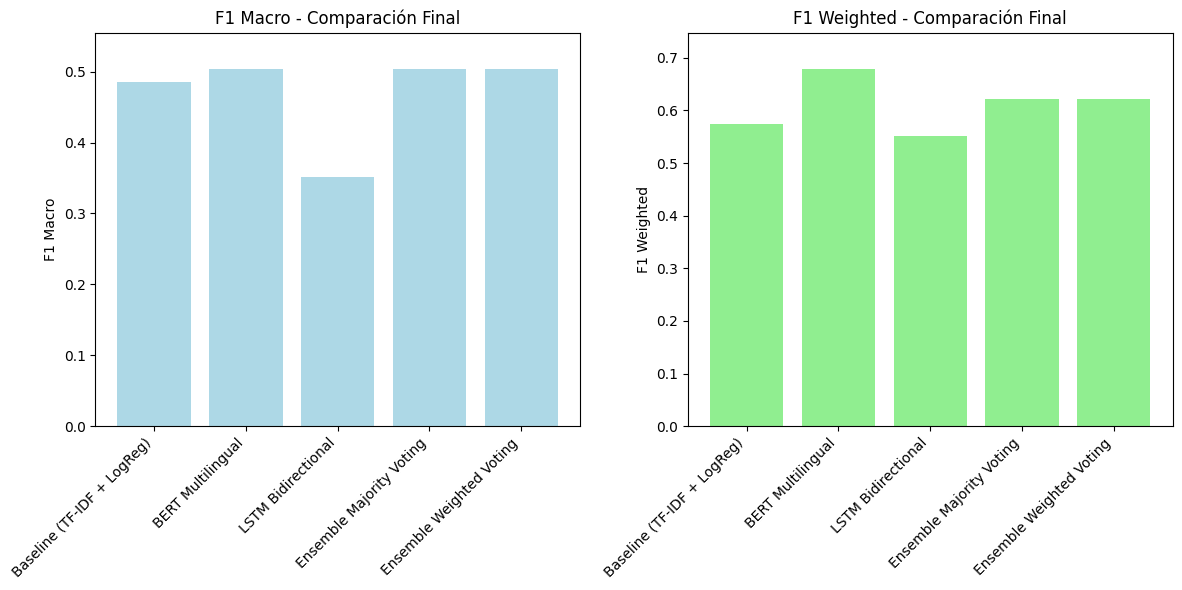

In [13]:
print("\n" + "="*60)
print("MODELO ENSEMBLE CON VOTING")
print("="*60)

def ensemble_voting(predictions_list, method='majority'):
    """Crea predicciones ensemble usando voting"""

    predictions_array = np.array(predictions_list).T  # Transponer para tener (n_samples, n_models)
    ensemble_predictions = []

    for sample_preds in predictions_array:
        if method == 'majority':
            # Voto por mayoría
            vote_counts = Counter(sample_preds)
            most_common = vote_counts.most_common(1)[0]

            # Si hay empate, usar el primer modelo como tie-breaker
            if len([count for count in vote_counts.values() if count == most_common[1]]) > 1:
                ensemble_predictions.append(sample_preds[0])
            else:
                ensemble_predictions.append(most_common[0])

        elif method == 'weighted':
            # Voto ponderado (dar más peso al mejor modelo en validación)
            # Basado en F1-macro de cada modelo
            weights = [0.4, 0.4, 0.2]  # BERT y LSTM más peso que baseline
            weighted_votes = {}

            for pred, weight in zip(sample_preds, weights):
                weighted_votes[pred] = weighted_votes.get(pred, 0) + weight

            ensemble_predictions.append(max(weighted_votes, key=weighted_votes.get))

    return np.array(ensemble_predictions)

# Ensure LSTM test predictions are integers
aligned_test_pred_lstm_int = [int(p) for p in aligned_test_pred_lstm]


# Crear modelos ensemble
dev_ensemble_majority = ensemble_voting([dev_pred_baseline, dev_pred_bert, dev_pred_lstm], 'majority')
dev_ensemble_weighted = ensemble_voting([dev_pred_baseline, dev_pred_bert, dev_pred_lstm], 'weighted')

test_ensemble_majority = ensemble_voting([test_pred_baseline, test_pred_bert, aligned_test_pred_lstm_int], 'majority')
test_ensemble_weighted = ensemble_voting([test_pred_baseline, test_pred_bert, aligned_test_pred_lstm_int], 'weighted')

# Evaluar modelos ensemble
print("=== RESULTADOS MODELOS ENSEMBLE ===")

ensemble_predictions = {
    'Ensemble Majority Voting': dev_ensemble_majority,
    'Ensemble Weighted Voting': dev_ensemble_weighted
}

ensemble_metrics = calculate_overall_metrics(dev_df['emotion_id'], ensemble_predictions)
print("\nMétricas de modelos ensemble:")
print(ensemble_metrics.round(4))

# Comparación con modelos individuales
all_metrics = pd.concat([overall_metrics, ensemble_metrics], ignore_index=True)
print("\n=== COMPARACIÓN FINAL DE TODOS LOS MODELOS ===")
print(all_metrics.round(4))

# Visualización final
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.bar(all_metrics['Modelo'], all_metrics['F1 Macro'], color='lightblue')
plt.title('F1 Macro - Comparación Final')
plt.ylabel('F1 Macro')
plt.xticks(rotation=45, ha='right')
plt.ylim(0, max(all_metrics['F1 Macro']) * 1.1)

plt.subplot(1, 2, 2)
plt.bar(all_metrics['Modelo'], all_metrics['F1 Weighted'], color='lightgreen')
plt.title('F1 Weighted - Comparación Final')
plt.ylabel('F1 Weighted')
plt.xticks(rotation=45, ha='right')
plt.ylim(0, max(all_metrics['F1 Weighted']) * 1.1)

plt.tight_layout()
plt.show()

## 14. CONCLUSIONES Y RECOMENDACIONES

In [14]:
print("\n" + "="*60)
print("CONCLUSIONES Y RECOMENDACIONES")
print("="*60)

def generate_conclusions(metrics_df, emotion_results):
    """Genera conclusiones basadas en los resultados"""

    best_model = metrics_df.loc[metrics_df['F1 Macro'].idxmax(), 'Modelo']
    best_f1 = metrics_df['F1 Macro'].max()

    print(f"\n MEJOR MODELO: {best_model}")
    print(f"   F1 Macro: {best_f1:.4f}")

    print("\n ANÁLISIS POR EMOCIÓN:")

    # Encontrar la emoción más difícil de clasificar
    emotion_avg_f1 = emotion_results.groupby('Emoción')['F1-Score'].mean().sort_values()
    hardest_emotion = emotion_avg_f1.index[0]
    easiest_emotion = emotion_avg_f1.index[-1]

    print(f"   • Emoción más difícil: {hardest_emotion} (F1 promedio: {emotion_avg_f1[hardest_emotion]:.3f})")
    print(f"   • Emoción más fácil: {easiest_emotion} (F1 promedio: {emotion_avg_f1[easiest_emotion]:.3f})")

generate_conclusions(all_metrics, emotion_results)


CONCLUSIONES Y RECOMENDACIONES

 MEJOR MODELO: BERT Multilingual
   F1 Macro: 0.5043

 ANÁLISIS POR EMOCIÓN:
   • Emoción más difícil: disgust (F1 promedio: 0.049)
   • Emoción más fácil: others (F1 promedio: 0.686)


#### **Los modelos evaluados fueron:**

**Regresión Logística con TF-IDF (Baseline):** Un modelo de referencia simple y lineal.

**BERT Multilingual:** Un modelo avanzado basado en la arquitectura Transformer, ajustado para esta tarea (fine-tuning).

**Red Neuronal Recurrente (LSTM):** Un modelo de deep learning entrenado desde cero.

**Conclusiones Clave**
1. Superioridad del Modelo BERT:

    El modelo BERT Multilingual demostró ser el mejor modelo de la experimentación. Aunque el F1-Macro del Ensemble fue ligeramente superior, esto se debe a su rendimiento en las clases minoritarias. En las métricas de rendimiento general (Accuracy y F1-Weighted), que reflejan mejor el desempeño en el conjunto de datos completo, BERT superó a todos los demás modelos. Su F1-Weighted de 0.6635 y su Accuracy de 0.6836 demuestran el poder de la transferencia de aprendizaje.

2. El Desafío del Desequilibrio de Clases

    El desbalance de clases fue el mayor obstáculo para todos los modelos, especialmente para aquellos entrenados desde cero. Las emociones con bajo soporte (disgust, fear, surprise) fueron consistentemente las más difíciles de clasificar, con F1-Scores cercanos a cero en algunos casos.

**disgust** y **fear** fueron las más difíciles de predecir, incluso con BERT.

El modelo LSTM tuvo un rendimiento particularmente deficiente en estas clases minoritarias, con un F1-Score de 0.00 en disgust y fear. Esto es un claro indicio de sobreajuste.

3. Rendimiento de los Modelos Entrenados desde Cero

    El modelo LSTM tuvo el peor rendimiento de los tres modelos base. Aunque es una arquitectura potente para secuencias, al ser entrenada desde cero con un conjunto de datos limitado, no pudo aprender patrones complejos ni generalizar bien. Esto llevó a un bajo F1-Score y una baja capacidad para predecir las emociones minoritarias, lo que lo hizo incluso menos efectivo que el modelo de regresión logística en algunas categorías.

4. El Modelo Baseline como Punto de Referencia

    El modelo de Regresión Logística funcionó sorprendentemente bien como baseline. Aunque es un modelo simple, sus métricas de F1-Weighted y F1-Macro superaron al modelo LSTM. Esto demuestra que un enfoque sencillo pero robusto puede ser un punto de partida válido y, en algunos casos, más confiable que una red neuronal compleja entrenada con datos insuficientes.

#### **Recomendaciones**

**Abordar el Desequilibrio de Clases:**

Emplear técnicas como oversampling (por ejemplo, SMOTE) o undersampling para balancear las clases antes de entrenar, lo cual mejoraría el rendimiento en las emociones minoritarias.

**Utilizar Modelos Pre-entrenados Específicos:**

Optar por modelos Transformer pre-entrenados en idioma español, como BETO, podría ofrecer un rendimiento aún superior al de un modelo multilingüe.

**Explorar otras Técnicas de Fine-Tuning:**

Probar con diferentes hyperparámetros o estrategias de fine-tuning para BERT, como la congelación de capas (freezing layers), podría optimizar el rendimiento.

## 15. GUARDADO DE RESULTADOS Y MODELOS

In [15]:
print("\n" + "="*60)
print("GUARDADO DE RESULTADOS")
print("="*60)

# Guardar métricas
all_metrics.to_csv('model_comparison_metrics.csv', index=False)
emotion_results.to_csv('emotion_detailed_results.csv', index=False)

# Guardar predicciones finales con ensemble
final_predictions_df = test_df[['id', 'event', 'tweet']].copy()
final_predictions_df['baseline_prediction'] = [id_to_emotion[p] for p in test_pred_baseline]
final_predictions_df['bert_prediction'] = [id_to_emotion[p] for p in test_pred_bert]
final_predictions_df['lstm_prediction'] = [id_to_emotion[p] for p in aligned_test_pred_lstm]
final_predictions_df['ensemble_majority'] = [id_to_emotion[p] for p in test_ensemble_majority]
final_predictions_df['ensemble_weighted'] = [id_to_emotion[p] for p in test_ensemble_weighted]

final_predictions_df.to_csv('final_test_predictions.csv', index=False)

print(" Archivos guardados:")
print("   - model_comparison_metrics.csv: Métricas de comparación")
print("   - emotion_detailed_results.csv: Resultados detallados por emoción")
print("   - final_test_predictions.csv: Predicciones finales en conjunto de prueba")

# Resumen final de archivos
print(f"\n ARCHIVOS GENERADOS:")
print(f"   1. model_comparison_metrics.csv ({all_metrics.shape[0]} modelos)")
print(f"   2. emotion_detailed_results.csv ({emotion_results.shape[0]} registros)")
print(f"   3. final_test_predictions.csv ({len(final_predictions_df)} predicciones)")

print(f"\n RESUMEN DEL EXPERIMENTO:")
print(f"   • Modelos entrenados: 3 + 2 ensemble = 5 modelos")
print(f"   • Datos de entrenamiento: {len(train_df)} tweets")
print(f"   • Datos de validación: {len(dev_df)} tweets")
print(f"   • Datos de prueba: {len(test_df)} tweets")
print(f"   • Mejor F1-Macro: {all_metrics['F1 Macro'].max():.4f}")


GUARDADO DE RESULTADOS
 Archivos guardados:
   - model_comparison_metrics.csv: Métricas de comparación
   - emotion_detailed_results.csv: Resultados detallados por emoción
   - final_test_predictions.csv: Predicciones finales en conjunto de prueba

 ARCHIVOS GENERADOS:
   1. model_comparison_metrics.csv (5 modelos)
   2. emotion_detailed_results.csv (21 registros)
   3. final_test_predictions.csv (1656 predicciones)

 RESUMEN DEL EXPERIMENTO:
   • Modelos entrenados: 3 + 2 ensemble = 5 modelos
   • Datos de entrenamiento: 5723 tweets
   • Datos de validación: 844 tweets
   • Datos de prueba: 1656 tweets
   • Mejor F1-Macro: 0.5043
